In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
from pylab import rcParams

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, KFold, train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, catboost as catb, lightgbm as lgbm

from scipy.stats import shapiro, mannwhitneyu

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import pickle

import warnings
warnings.simplefilter('ignore')

pd.set_option('display.max_columns', None)

In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [3]:
class DataPreprocessing():
    
    def __init__(self):
        
        # Общая переменная для выбросов
        self.medians_nan = None

        # Переменные для пропусков
        self.medians = None
        self.mode = None
                
        
    def fit(self, X):
        
        self.medians = X.median()

        # Переменные для пропусков
        self.medians_nan = X[['Annual Income', 'Months since last delinquent', 
                 'Bankruptcies', 'Credit Score']].median()
        self.mode = X['Years in current job'].mode()[0]
        
    
    def transform_nan(self, X):
        
        # Пропуски
        X[['Annual Income', 'Months since last delinquent', 
                 'Bankruptcies', 'Credit Score']] = X[['Annual Income', 'Months since last delinquent', 
                 'Bankruptcies', 'Credit Score']].fillna(self.medians_nan)
        X['Years in current job'] = X['Years in current job'].fillna(self.mode)
        
        return X
    
    def transform_outliers(self, X):
        
        # Выбросы
        
        # Annual Income
        Annual_Income_condition = (X['Annual Income'] > np.quantile(X['Annual Income'], q=0.95))
        X.loc[Annual_Income_condition, 'Annual Income'] = self.medians['Annual Income']
        
        # Tax Liens
        Tax_Liens_condition = (X['Tax Liens'] > np.quantile(X['Tax Liens'], q=0.99))

        X.loc[Tax_Liens_condition, 'Tax Liens']  = self.medians['Tax Liens']
        
        # Number of Open Accounts
        NoOA_condition = (X['Number of Open Accounts'] > 24)
        X.loc[NoOA_condition, 'Number of Open Accounts'] = self.medians['Number of Open Accounts']
    
        # Years of Credit History
        YoCH = (X['Years of Credit History'] > 35)
        X.loc[YoCH, 'Years of Credit History'] = self.medians['Years of Credit History']
    
        # Maximum Open Credit
        MOC_condition = (X['Maximum Open Credit'] < np.quantile(X['Maximum Open Credit'],
        q = 0.01)) | (X['Maximum Open Credit'] > np.quantile(X['Maximum Open Credit'], q = 0.99))
        X.loc[MOC_condition, 'Maximum Open Credit'] = self.medians['Maximum Open Credit']
        
        # Number of Credit Problems
        NoCP = (X['Number of Credit Problems'] > np.quantile(X['Number of Credit Problems'], q=0.9))
        X.loc[NoCP, 'Number of Credit Problems'] = self.medians['Number of Credit Problems']
        
        # Months since last delinquent
        Msld = (X['Months since last delinquent'] < np.quantile(X['Months since last delinquent'], q=0.01)) \
        | (X['Months since last delinquent'] > np.quantile(X['Months since last delinquent'], q=0.99))
        X.loc[Msld, 'Months since last delinquent'] = self.medians['Months since last delinquent']
    
        # Bankruptcies
        Bankruptcies_condition = (X['Bankruptcies'] < np.quantile(X['Bankruptcies'], q=0.01)) | \
        (X['Bankruptcies'] > np.quantile(X['Bankruptcies'], q=0.99)) 
        X.loc[Bankruptcies_condition, 'Bankruptcies'] = self.medians['Bankruptcies']
        
        # Current Loan Amount
        CLA_condition = (X['Current Loan Amount'] < np.quantile(X['Current Loan Amount'], q=0.01)) | \
        (X['Current Loan Amount'] > np.quantile(X['Current Loan Amount'], q=0.8)) 
        X.loc[CLA_condition, 'Current Loan Amount'] = self.medians['Current Loan Amount']
        
        # Current Credit Balance
        CCB_condition = (X['Current Credit Balance'] > 1000000)
        X.loc[CCB_condition, 'Current Credit Balance'] = self.medians['Current Credit Balance']
        
        # Monthly Debt
        MD_condition = (X['Monthly Debt'] > 42000)
        X.loc[MD_condition, 'Monthly Debt'] = self.medians['Monthly Debt']
        
        # Credit Score
        CS_condition = (X['Credit Score'] < np.quantile(X['Credit Score'], q=0.1)) | \
        (X['Credit Score'] > np.quantile(X['Credit Score'], q=0.9)) 
        X.loc[CS_condition, 'Credit Score'] = self.medians['Credit Score']
        
        
        # Удаление коррелирующих признаков
        X.drop(['Home Ownership_Rent', 'Number of Credit Problems'], axis=1, inplace=True)
        
        return X
        
        
    # Категоризирует категориальный признак Years in current job на на 4 группы
    def years_job_cat(self, X):
    
        X['Years_job_cat'] = 0


        X.loc[X['Years in current job'] == '< 1 year', 'Years_job_cat'] = 1

        X.loc[(X['Years in current job'] == '1 year') | 
                  (X['Years in current job'] == '2 years') | 
                  (X['Years in current job'] == '3 years') | 
                  (X['Years in current job'] == '4 years') | 
                  (X['Years in current job'] == '5 years'), 'Years_job_cat'] = 2

        X.loc[(X['Years in current job'] == '6 years') | 
                  (X['Years in current job'] == '7 years') | 
                  (X['Years in current job'] == '8 years') | 
                  (X['Years in current job'] == '9 years'), 'Years_job_cat'] = 3


        X.loc[X['Years in current job'] == '10+ years', 'Years_job_cat'] = 4

        X.drop(columns='Years in current job', inplace=True)

        return X
    
    
# Добавляет dummies для категориальных признаков, удаляет исходные, также удаляет признак Term_Short Term, так как он 
# обратно-линейно коррелирует с Term_Long Term, также делает разделение на X_train, X_valid, y_train, y_valid
class category_dummies():
    
    def add(X):

        for cat_colname in X.select_dtypes(include=['object', 'category']):
            X = pd.concat([X, pd.get_dummies(X[cat_colname], prefix=cat_colname)], axis=1)
    
            X.drop(columns=cat_colname, inplace=True)
    
        return X
    
    def rem(X):
        
        X.drop(columns='Term_Short Term', inplace=True)
        
        # Удаление признака Purpose_renewable energy, поскольку после train_test_split у валида на 1 колонку больше
        pre=['Purpose_renewable energy']
        X = X.drop([x for x in pre if x in X.columns], axis=1)
        
        return X    
    
    # Разбиение на X_train, X_valid, y_train, y_valid
    def split(T, V):
        TARGET_NAME = 'Credit Default'
        x_train = T.drop(columns=TARGET_NAME)
        x_valid = V.drop(columns=TARGET_NAME)
        Y_train = T[TARGET_NAME]
        Y_valid = V[TARGET_NAME]

        return x_train, x_valid, Y_train, Y_valid

    class stand():   
        
        def __init__(self):
            self.scaler = None
            self.feature_names_for_stand = None
                
                
                
        def stand(self, T, V):   
            self.feature_names_for_stand = T.select_dtypes(include=['float32', 'int64']).columns.to_list()
            self.scaler = StandardScaler()

            stand_features_train = self.scaler.fit_transform(T[self.feature_names_for_stand])
            stand_features_valid = self.scaler.transform(V[self.feature_names_for_stand])

            T[self.feature_names_for_stand] = stand_features_train
            V[self.feature_names_for_stand] = stand_features_valid  

        def stand_test(self, test):
                
            stand_features_test = self.scaler.transform(test[self.feature_names_for_stand])
            test[self.feature_names_for_stand] = stand_features_test    
    
    def balance(x, y):
        smote = SMOTE()

        x_train, Y_train = smote.fit_resample(x, y)
        
        return x_train, Y_train         

    class models():
        
        def __init__(self):
            
            self.final_gb_model = None
            self.top_features_gb = None
            
    
        def model_train_valid(self, X_t, y_t, X_v, y_v):
            # Изначальная модель, на основе которой беру feature_importances
            gb_model = GradientBoostingClassifier(max_depth=5,
                                         min_samples_leaf=7,
                                         n_estimators=60,
                                         learning_rate=0.01,
                                         random_state=42)

            gb_model.fit(X_t, y_t)
            y_train_pred_0 = gb_model.predict(X_t)
            y_valid_pred_0 = gb_model.predict(X_v)

            feature_importances_gb = pd.DataFrame(zip(X_t.columns, gb_model.feature_importances_),
                                         columns=['feature_name', 'feature_importance'])
            feature_importances_gb.sort_values(by='feature_importance', ascending=False, inplace=True)

            # После 13 признака важность составляет 0.00%
            self.top_features_gb = feature_importances_gb['feature_name'].values.tolist()[:13]

            # Финальная модель
            self.final_gb_model = GradientBoostingClassifier(max_depth=5,
                                         min_samples_leaf=7,
                                         n_estimators=60,
                                         learning_rate=0.01,
                                         random_state=42)

            self.final_gb_model.fit(X_t[self.top_features_gb], y_t)
            y_train_pred = self.final_gb_model.predict(X_t[self.top_features_gb])
            y_valid_pred = self.final_gb_model.predict(X_v[self.top_features_gb])

            get_classification_report(y_t, y_train_pred, y_v, y_valid_pred)
            
        def model_test(self, test):
            y_test_pred = self.final_gb_model.predict(test[self.top_features_gb])    
            return y_test_pred

In [4]:
class charts():
    
    def __init__(self):
        self.sample = None
        self.sample_C = None
        self.sample_T = None
        self.sample_C_T_0 = None
        self.sample_C_T_1 = None
        self.NO_TARGET_FEATURES = None
    
    # Строит графки корреляции нецелевых признаков к таргету
    def corr_chart_with_target(self, X):

        self.NO_TARGET_FEATURES = X.columns.drop(TARGET_NAME).tolist()
        rcParams['figure.figsize'] = 20, 15

        corr_with_target = X[self.NO_TARGET_FEATURES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

        sns.barplot(x=corr_with_target.values, y=corr_with_target.index)
        plt.show()
    
    # Строит матрицу корреляций для нецелевых признаков
    def corr_chart_no_target(self, X):
    
        rcParams['figure.figsize'] = 40, 40
        sns.set(font_scale=1.4)

        sns.heatmap(X[self.NO_TARGET_FEATURES].corr().round(3), annot=True, cmap='GnBu', linewidths=0.5)
        plt.show()  
        
    def target_distribution(X):
        
        rcParams['figure.figsize'] = 10, 8

        TARGET_NAME = 'Credit Default'
        sns.countplot(x=TARGET_NAME, data=X)
        plt.show()
    
    def outliers(X):
        
        NUM_FEATURES = []
        
        for i in X.columns[:12]:
            NUM_FEATURES.append(i) 
        
        rcParams['figure.figsize'] = 20, 15

        X[NUM_FEATURES].hist(bins=20)
        
        plt.show()
    
    def loan(self, X):
        
        self.sample = X[['Current Loan Amount', TARGET_NAME]]

        self.sample_C = self.sample['Current Loan Amount']
        self.sample_T = self.sample[TARGET_NAME]

        self.sample_C_T_1 = self.sample_C[self.sample[TARGET_NAME] == 1]
        self.sample_C_T_0 = self.sample_C[self.sample[TARGET_NAME] == 0]

        rcParams['figure.figsize'] = 10, 8


        sns.kdeplot(self.sample_C_T_0, shade=True, color='g')
        sns.kdeplot(self.sample_C_T_1, shade=True, color='r')
        
        plt.show()  
    
    def s_m(self, X):  
        
        print(f"Шапиро:  {shapiro(self.sample_C)}") 
        print(f"Манна Уитни:  {mannwhitneyu(self.sample_C_T_0, self.sample_C_T_1)}") 
        print(f"Мат ожидания {self.sample_C_T_0.mean(), self.sample_C_T_1.mean()}")

In [5]:
def get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred):
    print('TRAIN\n\n' + classification_report(y_train, y_train_pred))
    print('VALID\n\n' + classification_report(y_valid, y_valid_pred))
    print('CONFUSION MATRIX FOR VALID\n\n')
    print(pd.crosstab(y_valid, y_valid_pred))

In [6]:
DF_DATASET_PATH = 'C:/Users/Anar/OneDrive/Рабочий стол/banking_score/datasets/course_project_df.csv'
TRAIN_DATASET_PATH = 'C:/Users/Anar/OneDrive/Рабочий стол/banking_score/datasets/course_project_train.csv'
VALID_DATASET_PATH = 'C:/Users/Anar/OneDrive/Рабочий стол/banking_score/datasets/course_project_valid.csv'
TEST_DATASET_PATH = 'C:/Users/Anar/OneDrive/Рабочий стол/banking_score/datasets/course_project_test.csv'
RESULT_DATASET_PATH = 'C:/Users/Anar/OneDrive/Рабочий стол/banking_score/datasets/course_project_ALAVRENOV_predictions.csv'

In [7]:
df = pd.read_csv(DF_DATASET_PATH, sep=',')

In [8]:
TARGET_NAME = 'Credit Default'

In [9]:
train, valid = train_test_split(df, test_size=0.33, random_state=42, shuffle=True)

In [10]:
train = reduce_mem_usage(train)
preprocessor = DataPreprocessing()
preprocessor.fit(train)
train = preprocessor.transform_nan(train)
train = preprocessor.years_job_cat(train)
train = category_dummies.add(train)
train = category_dummies.rem(train)
train = preprocessor.transform_outliers(train)

Memory usage of dataframe is 0.69 MB
Memory usage after optimization is: 0.29 MB
Decreased by 57.4%


In [11]:
valid = reduce_mem_usage(valid)
valid = preprocessor.transform_nan(valid)
valid = preprocessor.years_job_cat(valid)
valid = category_dummies.add(valid)
valid = category_dummies.rem(valid)
valid = preprocessor.transform_outliers(valid)

Memory usage of dataframe is 0.34 MB
Memory usage after optimization is: 0.15 MB
Decreased by 57.2%


In [12]:
train.to_csv(TRAIN_DATASET_PATH, index=False, encoding='utf-8', sep=',')
valid.to_csv(VALID_DATASET_PATH, index=False, encoding='utf-8', sep=',')

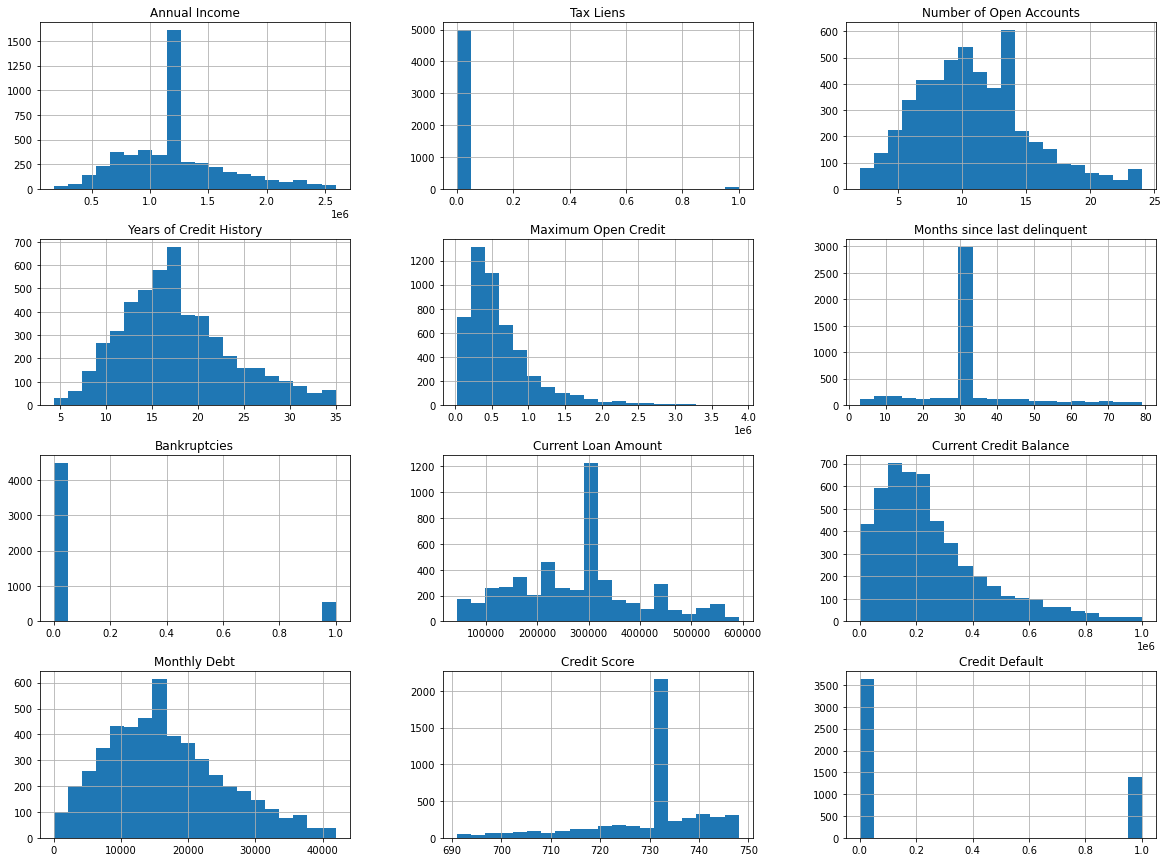

In [13]:
charts.outliers(train)

##### Анализ данных

Распределение целевого признака Credit Default. Буду считать, что есть дисбаланс классов, хоть и небольшой

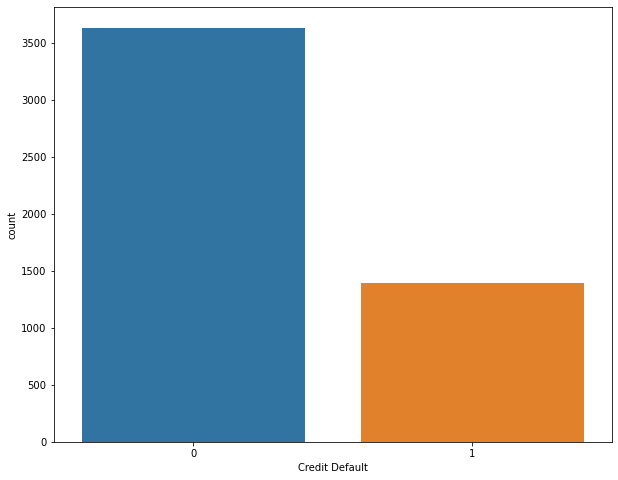

In [14]:
charts.target_distribution(train)

Корреляция нецелевых признаков с целевым

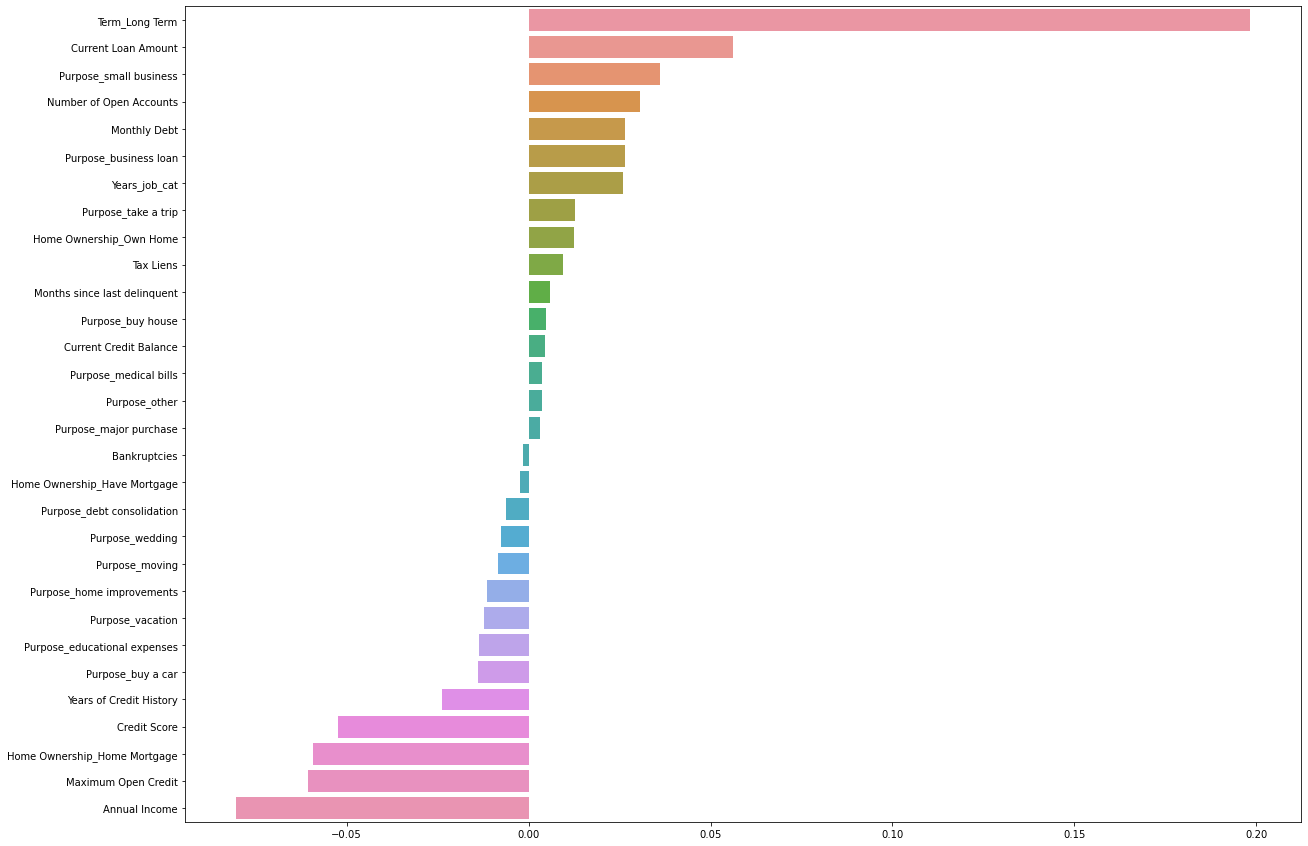

In [15]:
s = charts()
s.corr_chart_with_target(train)

Корреляция нецелевых признаков. Вижу, что Number of Сredit Problems & Bankruptcies и Home Ownership_Rent & Home Ownership_Home Mortgage сильно коррелируют между собой. Удаляю Home Ownership_Rent и Number of Credit Problems

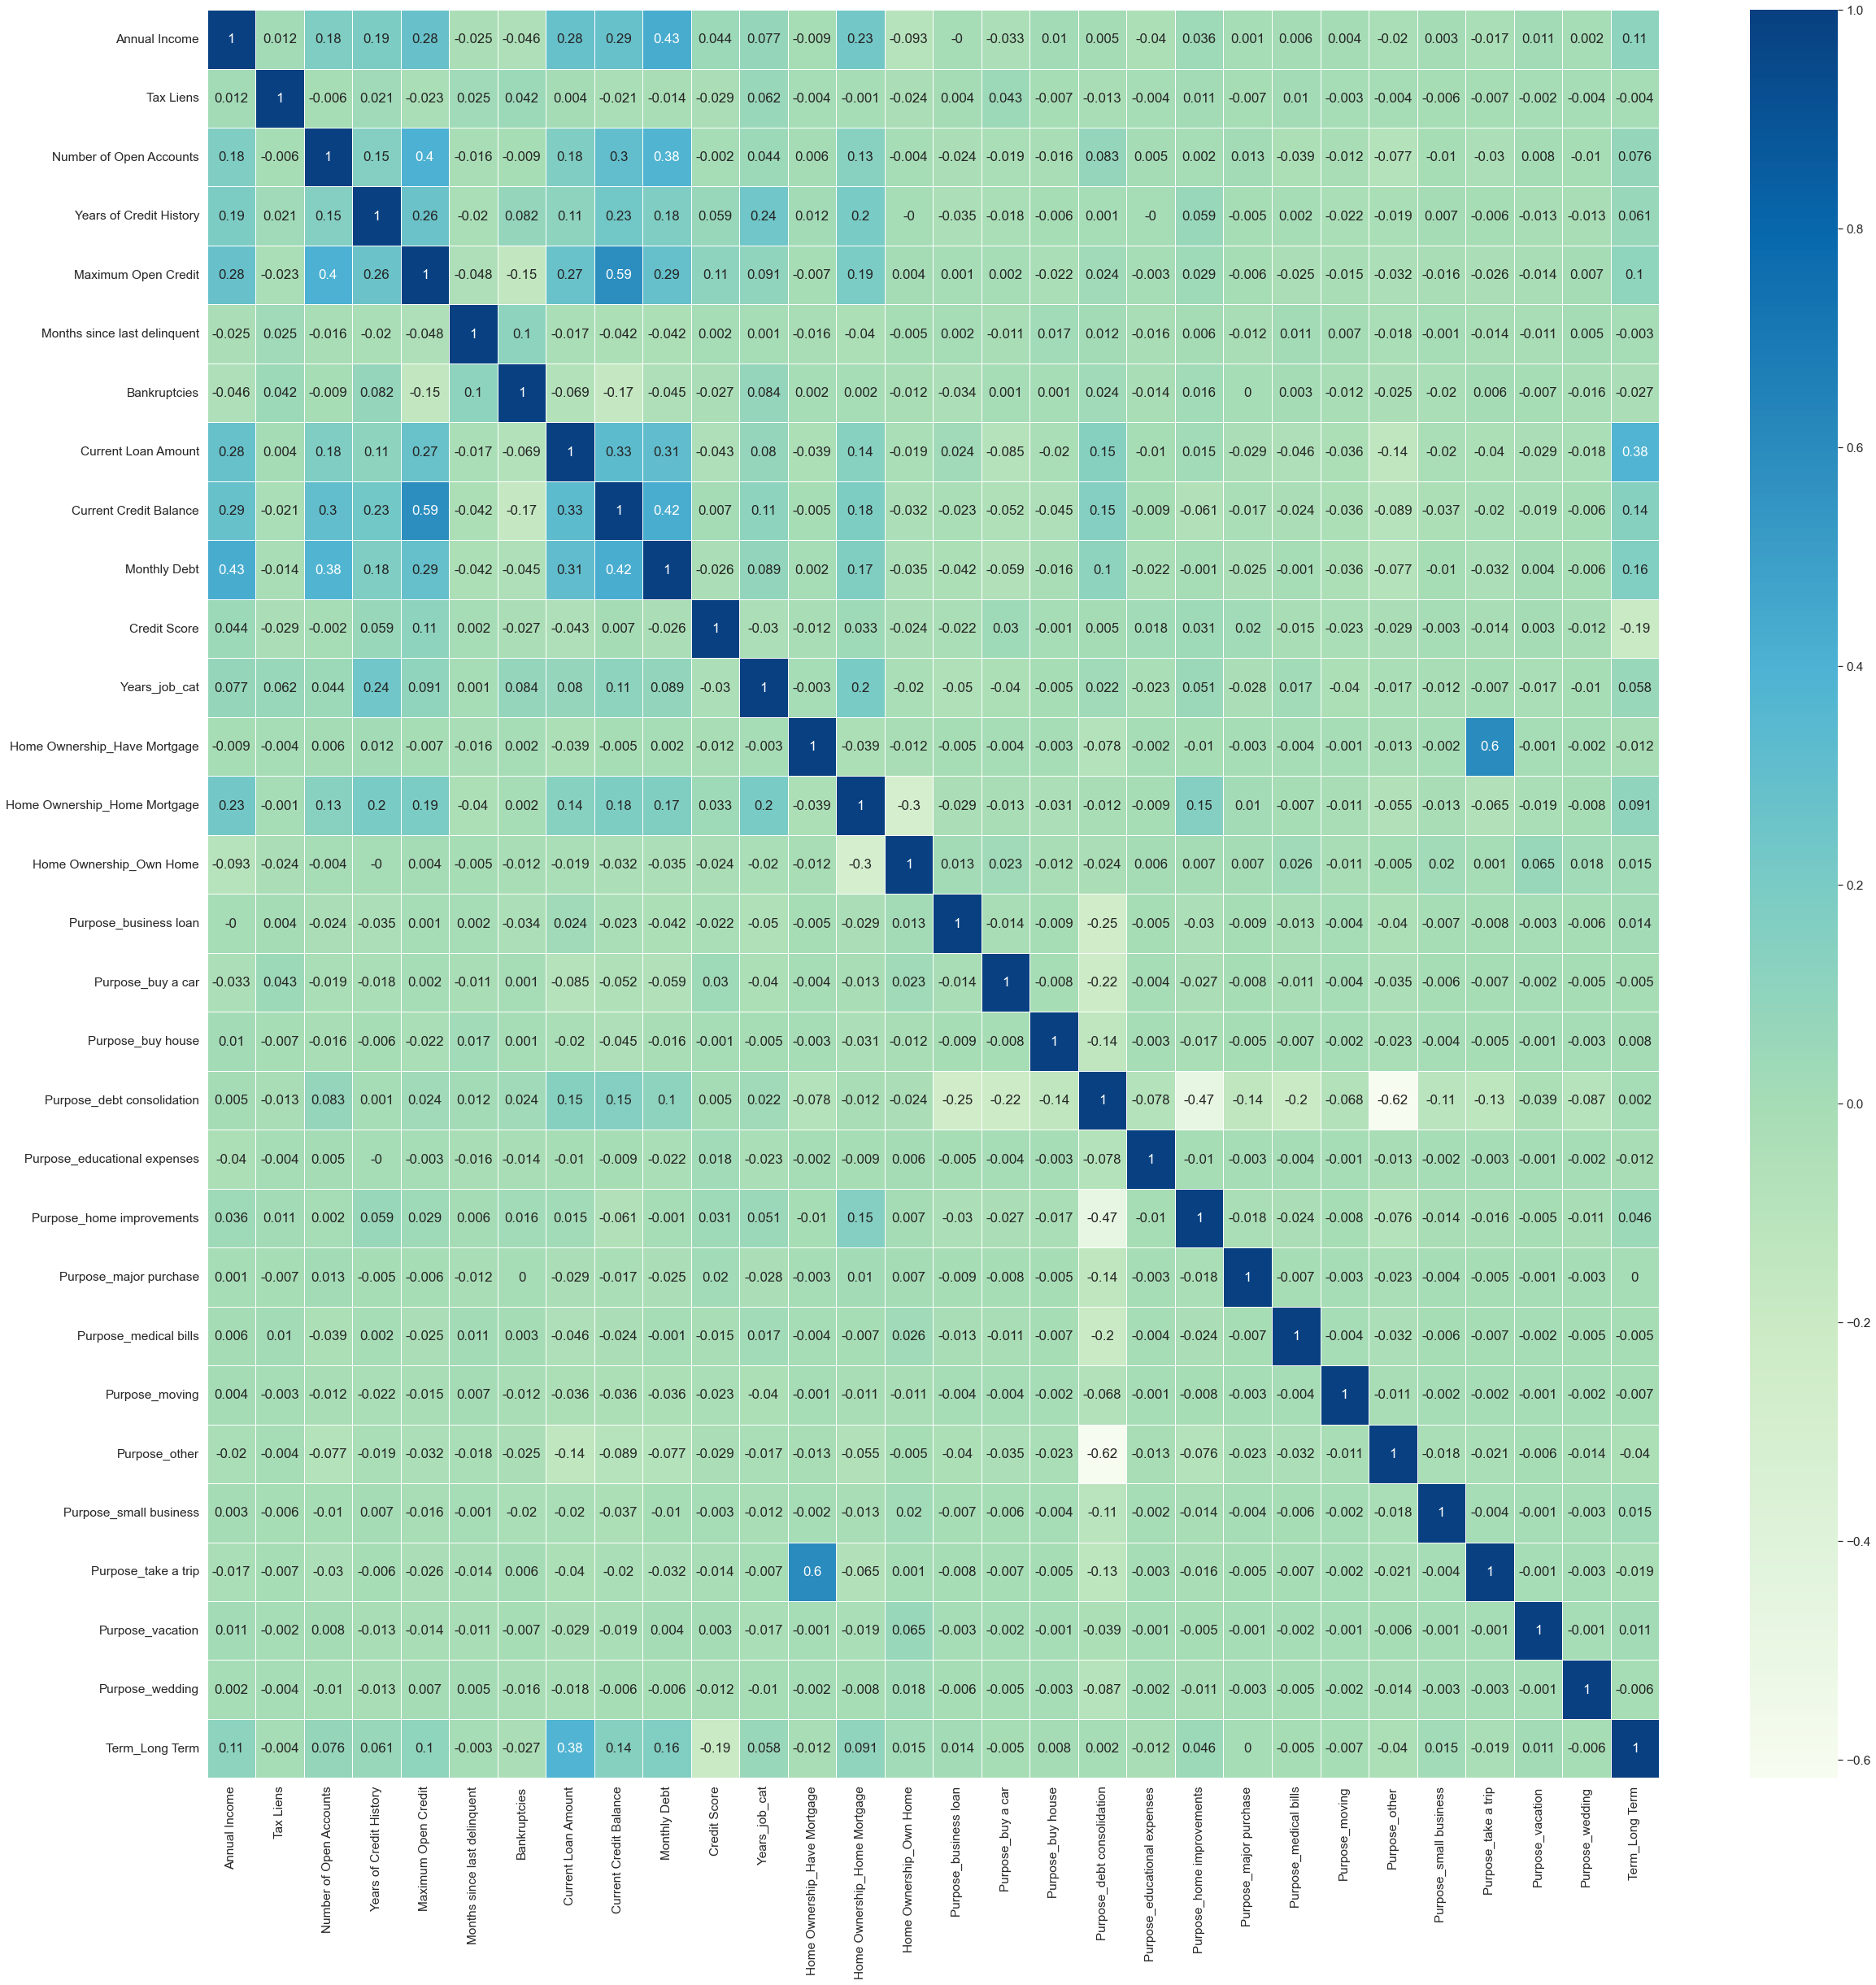

In [16]:
s.corr_chart_no_target(train)

Уровень значимости alpha = 0.05.  pvalue < alpha. Значит, гипотеза о равенстве мат ожиданий двух выборок отвергается,
значит, Current Loan Amount является значимым признаком в разрезе таргета

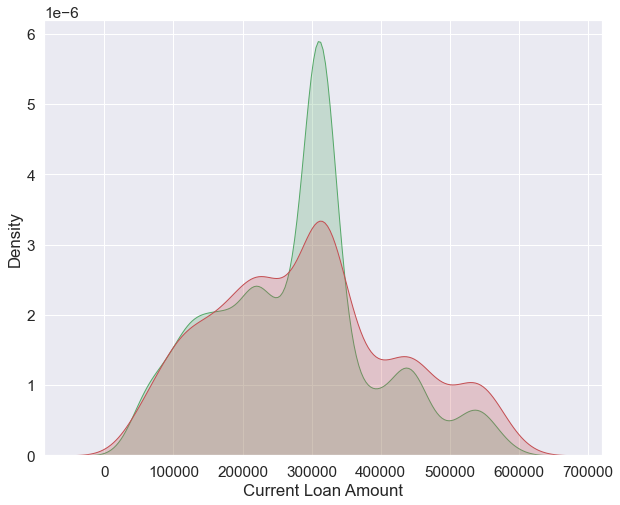

Шапиро:  ShapiroResult(statistic=0.9718531370162964, pvalue=2.4606608199435254e-30)
Манна Уитни:  MannwhitneyuResult(statistic=2379132.5, pvalue=0.0009344156886493658)
Мат ожидания (275713.71875, 290896.5)


In [17]:
loan_m_w = charts()
loan_m_w.loan(train)
loan_m_w.s_m(train)

##### Разбиение трейна и валида на X_train, X_valid, y_train, y_valid

In [18]:
X_train, X_valid, y_train, y_valid = category_dummies.split(train, valid)

##### Стандартизация признаков 

In [19]:
s = category_dummies.stand()
s.stand(X_train, X_valid)

##### Балансировка классов для X_train, y_train

In [20]:
X_train, y_train = category_dummies.balance(X_train, y_train)

##### Построение моделей

In [21]:
m = category_dummies.models()
m.model_train_valid(X_train, y_train, X_valid, y_valid)

TRAIN

              precision    recall  f1-score   support

           0       0.72      0.71      0.72      3631
           1       0.72      0.72      0.72      3631

    accuracy                           0.72      7262
   macro avg       0.72      0.72      0.72      7262
weighted avg       0.72      0.72      0.72      7262

VALID

              precision    recall  f1-score   support

           0       0.80      0.69      0.74      1756
           1       0.43      0.57      0.49       719

    accuracy                           0.65      2475
   macro avg       0.61      0.63      0.61      2475
weighted avg       0.69      0.65      0.67      2475

CONFUSION MATRIX FOR VALID


col_0              0    1
Credit Default           
0               1211  545
1                311  408


##### Работа с тестом

In [22]:
X_test = pd.read_csv(TEST_DATASET_PATH, sep=',')

In [23]:
X_test = reduce_mem_usage(X_test)
X_test = preprocessor.transform_nan(X_test)
X_test = preprocessor.years_job_cat(X_test)
X_test = category_dummies.add(X_test)
X_test = category_dummies.rem(X_test)
X_test = preprocessor.transform_outliers(X_test)
s.stand_test(X_test)
y_test_pred = m.model_test(X_test)
y_test_pred = pd.DataFrame(y_test_pred)
# y_test_pred.to_csv(RESULT_DATASET_PATH, encoding='utf-8', sep=',', index=False)

Memory usage of dataframe is 0.31 MB
Memory usage after optimization is: 0.13 MB
Decreased by 58.9%
